In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from tqdm import tqdm 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# Datasets:
# HIP_CER_df = pd.read_pickle('data/HIP_CER.pkl')
# ICC_df = pd.read_pickle('data/ICC_rms.pkl')
# SIMS_df = pd.read_pickle('data/SIMS.pkl')
# BIG_df = pd.read_pickle('data/30k_data.pkl')

In [95]:
class Object:
    def __init__(self, file_path, normalize=False):
        self.data = pd.read_pickle(file_path)
        
        if normalize:
            self._normalize_data()

        if 'type' in self.data.columns:
            self.X = self.data.drop('type', axis=1).copy()
            self.y = self.data['type'].copy()
            self.labels = None
            
            self._create_class_labels()
            
            self.X_train = None
            self.y_train = None
            self.X_test = None
            self.y_test = None
        
        else:
            self.X = self.data.copy()
            self.y = None

        # Define classifiers
        self.classifiers = {
            'LR':  LogisticRegression(max_iter=10000),
            'kNN': KNeighborsClassifier(),
            'SVM': SVC(),
            'RF': RandomForestClassifier(),
            'LDA': LinearDiscriminantAnalysis(),
            'GNB': GaussianNB(),
            'XGB': XGBClassifier()
        }

        # Define hyperparameter grid for each model
        LR_param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
        }

        kNN_param_grid = {
            'n_neighbors': np.arange(1, 20),
            'weights': ['uniform', 'distance']
        }

        SVM_param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
        }

        RF_param_grid = {
            'n_estimators': [100, 200, 300],  
            'max_depth': [None, 5, 10],       
            'min_samples_split': [2, 5, 10],  
            'min_samples_leaf': [1, 2, 4],  
            'max_features': ['sqrt', 'log2']
        }

        GNB_param_grid = {
            'var_smoothing': np.logspace(-13, -3, 100)
        }        
        
        LDA_param_grid = {
            'solver': ['svd', 'lsqr', 'eigen'],
        }

        XGB_param_grid = {
            'n_estimators': [100, 300, 500, 600, 700, 800, 1200],
            'learning_rate': [0.01, 0.1, 0.0001, 0.5, 0.2],
            'max_depth': [3, 4, 5, 8, 12, 18],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.5, 1.0, 0.1),
            'gamma': [0.001, 0.01, 0.1, 0, 1, 2]
        }

        # Define the parameter grids
        self.param_grids = {
            'LR': LR_param_grid,
            'kNN': kNN_param_grid,
            'SVM': SVM_param_grid,
            'RF': RF_param_grid,
            'GNB': GNB_param_grid,
            'LDA': LDA_param_grid,
            'XGB': XGB_param_grid
        }
        
        self.model = None
        self.y_pred = None

    def _normalize_data(self):
        numerical_columns = self.data.select_dtypes(include=['float64', 'int64']).columns
        print(f'Normalizing {len(numerical_columns)} columns...')
        scl= StandardScaler()
        self.data[numerical_columns] = scl.fit_transform(self.data[numerical_columns])

    def _create_class_labels(self):
        self.labels = LabelEncoder().fit_transform(self.y)

    def split_dataset(self, test_size=0.25):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.labels, stratify=self.labels, test_size=test_size, random_state=42)
        print(self.X_train.shape, self.X_test.shape)

    def tune_model(self, model_name):
        # Create a RandomizedSearchCV object
        random_search = RandomizedSearchCV(
            estimator=self.classifiers[model_name],
            param_distributions=self.param_grids[model_name],
            n_iter=200,  # Number of parameter settings that are sampled
            scoring='accuracy',
            n_jobs=-1,  # Use all available cores
            cv=3,  # Number of cross-validation 
            verbose=2,
            random_state=42
        )

        # Fit the RandomizedSearchCV object to the training data
        random_search.fit(self.X_train, self.y_train)
        # Get the best parameter combination found by RandomizedSearchCV
        best_params = random_search.best_params_
        # Create a new XGBoost classifier with the best parameters
        self.model = random_search.best_estimator_
        # Train the classifier on the training data
        self.model.fit(self.X_train, self.y_train)
        # Make predictions on the test data
        self.y_pred = self.model.predict(self.X_test)
        # Evaluate the accuracy of the classifier
        accuracy = accuracy_score(self.y_test, self.y_pred)
        print("Accuracy:", accuracy)

    def save_model(self, model_name):
        with open(model_name, 'wb') as file:
            pickle.dump(self.model, file)    

    def nested_cv(self, model_name):
        NUM_TRIALS = 3
        # Arrays to store scores
        nested_scores = []
        # Loop for each trial
        for i in tqdm(range(NUM_TRIALS)):
            
            inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
            outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

            # Nested CV with parameter optimization
            clf = RandomizedSearchCV(estimator=self.classifiers[model_name], scoring='accuracy', param_distributions=self.param_grids[model_name], 
                                     cv=inner_cv, n_iter=100, n_jobs=-1, verbose=0)
            
            nested_score = cross_val_score(clf, X=self.X_train, y=self.y_train, 
                                        scoring='accuracy', cv=outer_cv)
            
            nested_scores.append(list(nested_score))
        return clf, nested_scores
        

    def __str__(self) -> str:
        return f'Shape of dataset: {self.data.shape}'

MyData = Object('data/ICC_rms.pkl')     
MyData.split_dataset(test_size=.2)

(1235, 511) (309, 511)


## NestedCV

In [82]:
nested_LG, nested_scores_LG = MyData.nested_cv('LR')
nested_kNN, nested_scores_kNN = MyData.nested_cv('kNN')
nested_SVM, nested_scores_SVM = MyData.nested_cv('SVM')
nested_RF, nested_scores_RF = MyData.nested_cv('RF')
nested_LDA, nested_scores_LDA = MyData.nested_cv('LDA')
nested_GNB, nested_scores_GNB = MyData.nested_cv('GNB')

  0%|          | 0/3 [00:00<?, ?it/s]/home/WUR/g0012069/env/main/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/WUR/g0012069/env/main/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/WUR/g0012069/env/main/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/WUR/g0012069/env/main/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=100. Running 3 iterations. For exhaustive 

In [83]:
nested_scores_LG = [item for sublist in nested_scores_LG for item in sublist]
nested_scores_kNN = [item for sublist in nested_scores_kNN for item in sublist]
nested_scores_RF = [item for sublist in nested_scores_RF for item in sublist]
nested_scores_SVM = [item for sublist in nested_scores_SVM for item in sublist]
nested_scores_LDA = [item for sublist in nested_scores_LDA for item in sublist]
nested_scores_GNB = [item for sublist in nested_scores_GNB for item in sublist]


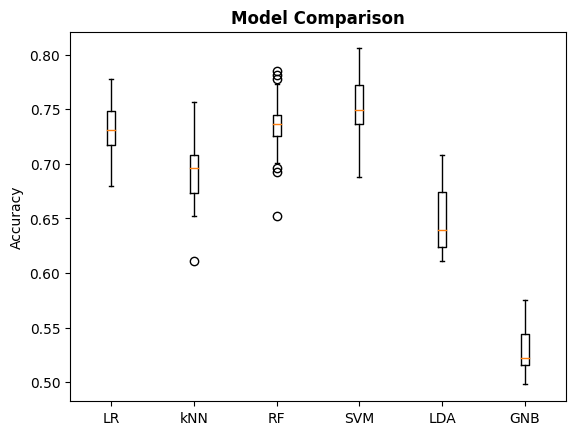

In [84]:
# create box plot
fig, ax = plt.subplots()
positions = [1, 2, 3, 4, 5, 6] # x-axis positions for each box plot
ax.boxplot([nested_scores_LG, nested_scores_kNN, nested_scores_RF, nested_scores_SVM, nested_scores_LDA, nested_scores_GNB], positions=positions, widths=0.1)

# add title and labels
ax.set_title('Model Comparison', fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_xticks(positions)
ax.set_xticklabels(['LR', 'kNN', 'RF', 'SVM', 'LDA', 'GNB'])

# show plot
plt.show()

In [96]:
MyData.tune_model(model_name='SVM')

/home/WUR/g0012069/env/main/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 196 is smaller than n_iter=200. Running 196 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 196 candidates, totalling 588 fits
[CV] END ......................C=0.001, gamma=1, kernel=poly; total time=   0.7s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.8s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.8s
[CV] END ..................C=0.001, gamma=0.1, kernel=linear; total time=   0.9s
[CV] END ....................C=0.001, gamma=0.1, kernel=poly; total time=   0.9s
[CV] END ..................C=0.001, gamma=0.001, kernel=poly; total time=   0.9s
[CV] END ..............C=0.001, gamma=0.0001, kernel=sigmoid; total time=   0.9s
[CV] END .................C=0.001, gamma=0.0001, kernel=poly; total time=   0.9s
[CV] END ................C=0.001, gamma=0.001, kernel=linear; total time=   0.9s[CV] END ...............C=0.001, gamma=0.001, kernel=sigmoid; total time=   0.9s

[CV] END ...................C=0.001, gamma=1, kernel=sigmoid; total time=   0.9s
[CV] END ...................C=0.001, gamma=1, 

In [97]:
MyData.tune_model('RF')

/home/WUR/g0012069/env/main/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 162 is smaller than n_iter=200. Running 162 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.7s[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split

In [98]:
MyData.tune_model('XGB')

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] END colsample_bytree=0.5, gamma=2, learning_rate=0.01, max_depth=12, n_estimators=100, subsample=0.5; total time=   3.2s
[CV] END colsample_bytree=0.5, gamma=2, learning_rate=0.01, max_depth=12, n_estimators=100, subsample=0.5; total time=   4.1s
[CV] END colsample_bytree=0.5, gamma=2, learning_rate=0.01, max_depth=12, n_estimators=100, subsample=0.5; total time=   4.1s
[CV] END colsample_bytree=0.5, gamma=2, learning_rate=0.2, max_depth=18, n_estimators=100, subsample=0.5; total time=   4.2s
[CV] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.5, max_depth=12, n_estimators=100, subsample=0.7999999999999999; total time=   4.3s
[CV] END colsample_bytree=0.7, gamma=0.01, learning_rate=0.5, max_depth=12, n_estimators=100, subsample=0.7999999999999999; total time=   4.3s
[CV] END colsample_bytree=0.5, gamma=2, learning_rate=0.2, max_depth=18, n_estimators=100, subsample=0.5; total time=   4.4s
[CV] END colsample_bytr

## ANN 

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2)
        self.fc3 = nn.Linear(hidden_size * 2, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)  # Add dropout with a probability of 0.5

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [122]:
# Convert the training and testing sets to tensors
X_train = torch.tensor(MyData.X_train.values, dtype=torch.float32)
y_train = torch.tensor(MyData.y_train, dtype=torch.float32)
X_test = torch.tensor(MyData.X_test.values, dtype=torch.float32)
y_test = torch.tensor(MyData.y_test, dtype=torch.float32)

# Reshape the labels
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [138]:
# Create an instance of the model
input_size = X_train.shape[1]  # Number of features in the input data
hidden_size = 500  # Number of units in the hidden layer
model = BinaryClassifier(input_size, hidden_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 250 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Test the model
predictions = model(X_test)
y_pred = predictions.round().detach().numpy()

Epoch 250/1000, Loss: 0.5008920431137085
Epoch 500/1000, Loss: 0.3732852637767792
Epoch 750/1000, Loss: 0.29549843072891235
Epoch 1000/1000, Loss: 0.22465546429157257


In [140]:
print(accuracy_score(y_test, y_pred))

0.7605177993527508
